In [108]:
%run ./VA_sentencing_reform_v1_utils.ipynb

52291


In [116]:
reload(incarceration_transitions)
reload(population_simulation)

<module 'spark.sentencing_policy_impact_v1.population_simulation' from '../../spark/sentencing_policy_impact_v1/population_simulation.py'>

In [10]:
# Sample of the input data
jail_prison_admissions.head()

,offense_group,offense_code,off1_vcc,judge_id,year,effective_sentence_months,effective_sentence_years,life_sentence,offense_date,outflow_from,sentence_type,simulation_group_name
0,ASSAULT,ASL1316,ASL1316F6,0,2018.0,18.0,1.500000,0.0,5/20/2017,pretrial,prison,ASL1316
1,ASSAULT,ASL1316,ASL1316F6,0,2019.0,10.0,0.833333,0.0,4/25/2018,pretrial,prison,ASL1316
4,ASSAULT,ASL1316,ASL1316F6,10DB,2017.0,7.0,0.583333,0.0,12/25/2016,pretrial,prison,ASL1316
5,ASSAULT,ASL1316,ASL1316F6,10DB,2019.0,7.0,0.583333,0.0,11/17/2018,pretrial,prison,ASL1316
7,ASSAULT,ASL1316,ASL1316F6,10KW,2017.0,14.0,1.166667,0.0,12/11/2016,pretrial,prison,ASL1316


In [4]:
# Sentence count per type (prison/jail)
jail_prison_admissions['sentence_type'].value_counts(dropna=False)

prison    33847
jail      18444
Name: sentence_type, dtype: int64

In [5]:
# Policy Options
manditory_minimum_reduction = incarceration_transitions.IncarceratedTransitions.apply_mandatory_minimum_reduction
reduce_manditory_minimum_5y = partial(manditory_minimum_reduction, sentence_reduction_years=5)
abolish_manditory_minimum = partial(manditory_minimum_reduction, sentence_reduction_years=None)

In [56]:
# Policy Option Methods
def replace_sentence_distribution_with_other_offense(df, offense_codes):
    offense_data = df[df['offense_code'].isin(offense_codes)]
    offense_data_sample = sample_by_offense_year(offense_data)
    return partial(incarceration_transitions.IncarceratedTransitions.use_alternate_sentence_data, 
                   alternate_historical_admissions=offense_data_sample)

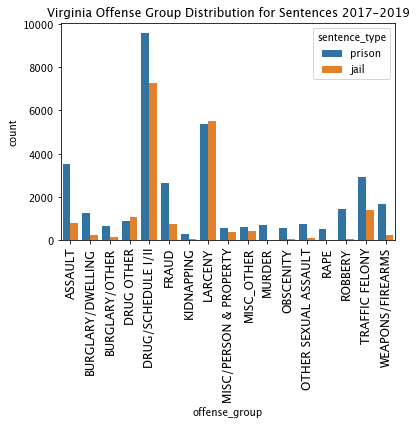

In [7]:
# Offense Group Options
offense_group_chart = sns.countplot(data=jail_prison_admissions, x='offense_group',hue='sentence_type')
offense_group_chart.set_title('Virginia Offense Group Distribution for Sentences 2017-2019')
chart_axis_label = offense_group_chart.set_xticklabels(offense_group_chart.get_xticklabels(), rotation=90, 
                                                       fontsize='large')

In [57]:
# Policy Selections per offense group
policy_df = pd.DataFrame([
    {'simulation_group_name': 'NAR3038', 'year': 2020, 'compartment': 'prison', 'policies': None, 
     'replacement_offenses': ['NAR3043']
    },
    {'simulation_group_name': 'NAR3087', 'year': 2020, 'compartment': 'prison', 'policies': None,
     'replacement_offenses': ['NAR3043']
    },
])
policy_df

,simulation_group_name,year,compartment,policies,replacement_offenses
0,NAR3038,2020,prison,None,[NAR3043]
1,NAR3087,2020,prison,None,[NAR3043]


In [151]:
def sample_by_offense_year(simulation_data):
    
    # maintain a list of the sampled data
    sample_rows = []

#     for offense_code, offense_code_group in simulation_data.groupby('offense_code'):
#         for year, offense_code_year_group in offense_code_group.groupby('year'):

#             # sample from the cohort DF with replacement
#             sample_idx = np.random.choice(offense_code_year_group.index, size=len(offense_code_year_group), 
#                                           replace=True)
#             sample_rows.extend(offense_code_year_group.loc[sample_idx].reset_index().T.to_dict().values())
    for offense_code, offense_code_group in simulation_data.groupby('offense_code'):
        print(f"Sampling from offense {offense_code} with {len(offense_code_group)} instances")

        # sample from the cohort DF with replacement
        sample_idx = np.random.choice(offense_code_group.index, size=len(offense_code_group), 
                                      replace=True)
        sample_rows.extend(offense_code_group.loc[sample_idx].reset_index().T.to_dict().values())
    return pd.DataFrame(sample_rows).drop(['index'], axis=1)

In [81]:
def expand_replacement_offense_policies(policy_df):
    bootstrapped_policy_df = pd.DataFrame(columns=policy_df.columns)
    for index, row in policy_df.iterrows():
        bootstrapped_policy_df.loc[index] = row
        bootstrapped_policy_df.loc[index, 'policies'] = [replace_sentence_distribution_with_other_offense(
            jail_prison_admissions, row['replacement_offenses']
        )]
    return bootstrapped_policy_df

In [104]:
def bootstrap_simulation(simulation_data, user_inputs, policy_df, num_iterations=2000):
    
    iteration_list = []
    for index in range(num_iterations):
        simulation_sample_data = sample_by_offense_year(simulation_data)
        bootstrapped_policy_df = expand_replacement_offense_policies(policy_df)
        
        policy_projection = population_simulation.PopulationSimulation()
        policy_results = policy_projection.simulate_sentencing_policies(simulation_sample_data, user_inputs, bootstrapped_policy_df)
    
        iteration_list.extend(policy_results.reset_index().T.to_dict().values())
        
    iteration_df = pd.DataFrame(iteration_list).drop(['index'], axis=1)
    bootstrap_results = pd.DataFrame()
    for index, ((compartment, year, simulation_group), group) in \
        enumerate(iteration_df.groupby(['compartment', 'year', 'simulation_group'])):
    
        bootstrap_results.loc[index, 'compartment'] = compartment
        bootstrap_results.loc[index, 'year'] = year
        bootstrap_results.loc[index, 'simulation_group'] = simulation_group
        bootstrap_results.loc[index, 'total_population'] = np.percentile(group['total_population'], 0.5)
        bootstrap_results.loc[index, 'total_population_high'] = np.percentile(group['total_population'], 0.975)
        bootstrap_results.loc[index, 'total_population_low'] = np.percentile(group['total_population'], 0.025)
        
    return bootstrap_results

In [100]:
impacted_offense_codes = policy_df['simulation_group_name'].unique()
simulation_data = jail_prison_admissions[jail_prison_admissions['offense_code'].isin(impacted_offense_codes)]
print(f"{simulation_data['simulation_group_name'].nunique()} simulation groups for {len(simulation_data)} sentences")

2 simulation groups for 887 sentences


In [132]:
user_inputs = {'projection_years': 10}
policy_results = bootstrap_simulation(simulation_data, user_inputs, policy_df, num_iterations=2000)
policy_results

,compartment,year,simulation_group,total_population,total_population_high,total_population_low
0,jail,2000.0,NAR3038,0.000000,0.000000,0.000000
1,jail,2000.0,NAR3087,0.000000,0.000000,0.000000
2,jail,2001.0,NAR3038,0.000000,0.000000,0.000000
3,jail,2001.0,NAR3087,0.000000,0.000000,0.000000
4,jail,2002.0,NAR3038,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
235,release,2027.0,NAR3087,1082.760618,1085.667403,1075.671827
236,release,2028.0,NAR3038,4578.519543,4581.941068,4568.083936
237,release,2028.0,NAR3087,1124.964123,1127.444059,1117.716023
238,release,2029.0,NAR3038,4689.242177,4692.862303,4678.466355


In [133]:
no_policy_df = pd.DataFrame(columns=policy_df.columns)
no_policy_results = bootstrap_simulation(simulation_data, user_inputs, no_policy_df, num_iterations=2000)
no_policy_results

,compartment,year,simulation_group,total_population,total_population_high,total_population_low
0,jail,2000.0,NAR3038,0.000000,0.000000,0.000000
1,jail,2000.0,NAR3087,0.000000,0.000000,0.000000
2,jail,2001.0,NAR3038,0.000000,0.000000,0.000000
3,jail,2001.0,NAR3087,0.000000,0.000000,0.000000
4,jail,2002.0,NAR3038,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
235,release,2027.0,NAR3087,625.410068,629.863482,614.581123
236,release,2028.0,NAR3038,4021.826376,4030.113704,4001.455958
237,release,2028.0,NAR3087,657.890986,663.137906,646.627842
238,release,2029.0,NAR3038,4139.577088,4147.467716,4118.420425


In [134]:
simulation_results = format_simulation_bootstrapped_results(policy_results, 'abolish_drug_mm')
simulation_results = simulation_results.merge(format_simulation_bootstrapped_results(no_policy_results, 'no_policies'), 
                                              on=['compartment', 'year'])
simulation_results = simulation_results[simulation_results['compartment'] != 'pretrial']
simulation_results_vis = simulation_results[(simulation_results['year'] >= 2016)
                                            & (simulation_results['compartment'] == 'prison')]

In [135]:
simulation_results_vis.head()

,compartment,year,abolish_drug_mm_total_population,abolish_drug_mm_total_population_high,abolish_drug_mm_total_population_low,no_policies_total_population,no_policies_total_population_high,no_policies_total_population_low
76,prison,2016.0,1930.597283,1939.341137,1894.891603,1925.888876,1939.236229,1868.845786
77,prison,2017.0,1939.836939,1949.610539,1903.643236,1935.096460,1948.280085,1877.716730
78,prison,2018.0,1931.807991,1943.314010,1898.650267,1930.197144,1941.432344,1873.427539
79,prison,2019.0,1931.278122,1942.416534,1897.041905,1930.226696,1940.083084,1873.805356
80,prison,2020.0,1541.668568,1547.504585,1523.253240,1928.515334,1936.596170,1872.732001


(0.0, 2028.7453341465798)

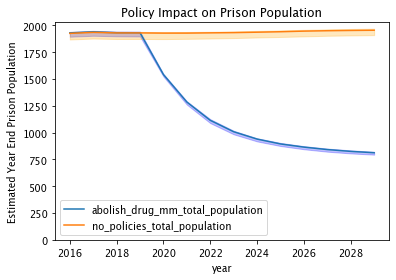

In [145]:
simulation_results_vis[simulation_results_vis['compartment'] == 'prison'].plot(
    x='year', y=['abolish_drug_mm_total_population', 'no_policies_total_population']
)
plt.fill_between(simulation_results_vis['year'],
                 simulation_results_vis['abolish_drug_mm_total_population_low'], 
                 simulation_results_vis['abolish_drug_mm_total_population_high'], color='blue', alpha=0.25)

plt.fill_between(simulation_results_vis['year'],
                 simulation_results_vis['no_policies_total_population_low'], 
                 simulation_results_vis['no_policies_total_population_high'], color='orange', alpha=0.25)

plt.title("Policy Impact on Prison Population")
plt.ylabel("Estimated Year End Prison Population")
plt.legend(loc='lower left')
plt.ylim([0, None])


In [140]:
prison_results = simulation_results[simulation_results['compartment'] == 'prison']
population_differential = pd.DataFrame(prison_results['abolish_drug_mm_total_population'] -  prison_results['no_policies_total_population'],
                                       columns=['population_difference'])
population_differential.index=prison_results['year']
population_differential

,population_difference
year,
2000.0,0.000000
2001.0,-0.001926
2002.0,-0.118909
2003.0,-1.181514
2004.0,-0.224851
2005.0,1.145780
2006.0,-2.256755
2007.0,-1.778507
2008.0,-3.504092


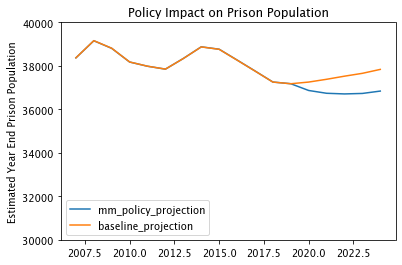

In [142]:
from spark.sentencing_policy_impact_v1.historical_data import total_state_responsible_adult_population
population_differential = population_differential[population_differential.index.isin(total_state_responsible_adult_population.index)]
projection_results = pd.DataFrame({
    'baseline_projection': total_state_responsible_adult_population, 
    'mm_policy_projection': total_state_responsible_adult_population + population_differential['population_difference']
})
projection_results.plot(y=['mm_policy_projection', 'baseline_projection'], ylim=[30000, 40000])
plt.title("Policy Impact on Prison Population")
plt.ylabel("Estimated Year End Prison Population")
plt.legend(loc='lower left')


Sampling from offense NAR3038 with 701 instances
Sampling from offense NAR3087 with 186 instances
Sampling from offense NAR3038 with 701 instances
Sampling from offense NAR3087 with 186 instances


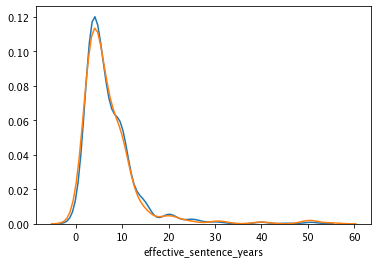

In [152]:
ax = None
for index in range(2):
    sample_df = sample_by_offense_year(simulation_data)
    ax = sns.distplot(sample_df['effective_sentence_years'], hist=False, ax=ax)